In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import datetime
#from datetime import datetime
from sklearn.metrics import mean_squared_error,accuracy_score,r2_score
from sklearn.model_selection import train_test_split

datetime64[ns]
           Symbol     Open     High      Low    Close Percent Change  \
Date                                                                   
2023-02-05  NEPSE  2096.70  2118.27  2087.69  2096.08           0.07   
2023-02-02  NEPSE  2118.56  2126.14  2090.14  2094.54          -1.04   
2023-02-01  NEPSE  2111.44  2124.30  2104.48  2116.65           0.24   
2023-01-31  NEPSE  2130.29  2136.44  2107.77  2111.68          -0.74   
2023-01-30  NEPSE  2166.31  2174.66  2124.83  2127.52          -1.89   

                  Volume   Prev_Volume  
Date                                    
2023-02-05  1.931719e+09  2.096419e+09  
2023-02-02  2.096419e+09  1.767052e+09  
2023-02-01  1.767052e+09  2.824540e+09  
2023-01-31  2.824540e+09  3.302202e+09  
2023-01-30  3.302202e+09  3.017064e+09  


,Close,Prev_Volume
Date,,
2023-02-05,2096.08,2.096419e+09
2023-02-02,2094.54,1.767052e+09
2023-02-01,2116.65,2.824540e+09
2023-01-31,2111.68,3.302202e+09
2023-01-30,2127.52,3.017064e+09


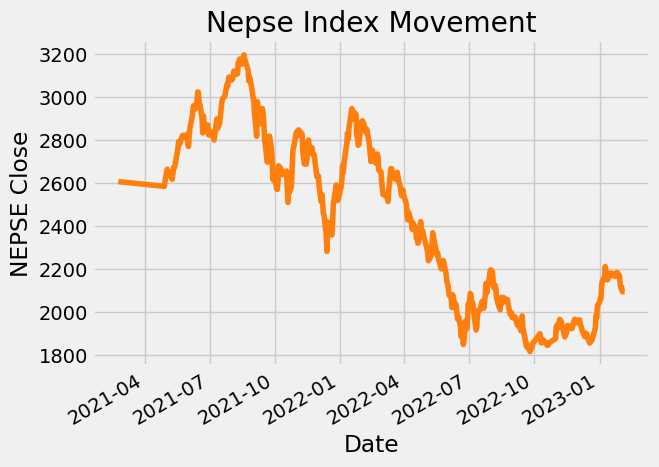

In [2]:
s = 8
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
df = pd.read_excel('NEPSE.xlsx',parse_dates=True,skiprows=0,index_col='Date')
print(df.index.dtype)
df['Prev_Volume'] = df['Volume'].shift(-1)
df.replace(0,np.nan,inplace=True)
df=df.dropna()
print(df.head())
df = df[['Close','Prev_Volume']]
fig,ax =plt.subplots()
df['Close'].plot(color = color_pal[1],ax=ax)
plt.title('Nepse Index Movement')
plt.ylabel('NEPSE Close')
df.head()

In [3]:
def create_features(df):
    df=df.copy()
    df['year']=df.index.year
    df['day_of_week']=df.index.dayofweek
    df['quarter']=df.index.quarter
    df['day']=df.index.day
    df['month']=df.index.month
    return df

                Close  Prev_Volume      year  day_of_week   quarter       day  \
Close        1.000000     0.777057 -0.674537     0.003951 -0.222191 -0.023433   
Prev_Volume  0.777057     1.000000 -0.573460    -0.036109 -0.114679 -0.019692   
year        -0.674537    -0.573460  1.000000     0.006294 -0.418644 -0.021271   
day_of_week  0.003951    -0.036109  0.006294     1.000000 -0.010651 -0.016186   
quarter     -0.222191    -0.114679 -0.418644    -0.010651  1.000000  0.014804   
day         -0.023433    -0.019692 -0.021271    -0.016186  0.014804  1.000000   
month       -0.227965    -0.100473 -0.443580    -0.014337  0.970724  0.012317   

                month  
Close       -0.227965  
Prev_Volume -0.100473  
year        -0.443580  
day_of_week -0.014337  
quarter      0.970724  
day          0.012317  
month        1.000000  


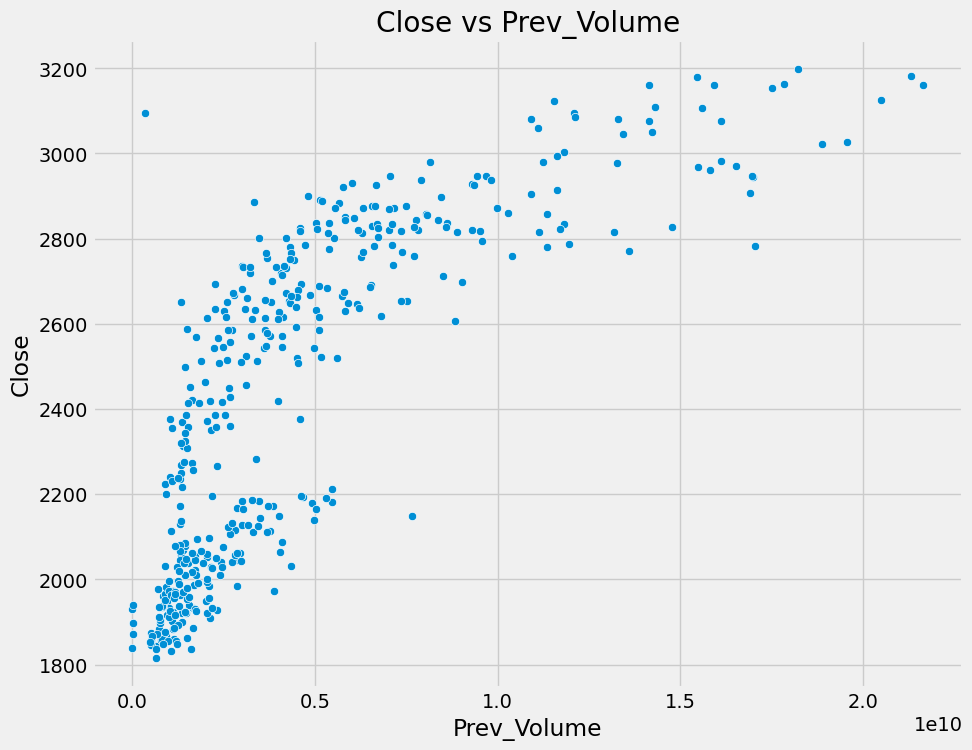

In [4]:
df_n = create_features(df)
fig,ax =plt.subplots(figsize=(10,8))
print(df_n.corr())
sns.scatterplot(data=df_n,x='Prev_Volume',y='Close')
ax.set_title('Close vs Prev_Volume')
plt.show()

In [5]:
X=df_n.drop('Close',axis=1)
print(X.head())
y=df_n['Close']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=s)

             Prev_Volume  year  day_of_week  quarter  day  month
Date                                                            
2023-02-05  2.096419e+09  2023            6        1    5      2
2023-02-02  1.767052e+09  2023            3        1    2      2
2023-02-01  2.824540e+09  2023            2        1    1      2
2023-01-31  3.302202e+09  2023            1        1   31      1
2023-01-30  3.017064e+09  2023            0        1   30      1


[10:06:56] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "early_stoping_rounds", "n_estimator" } are not used.

The score for XGBoost is 0.9778828743131914
The score for RandomForest is 0.9808459866731114


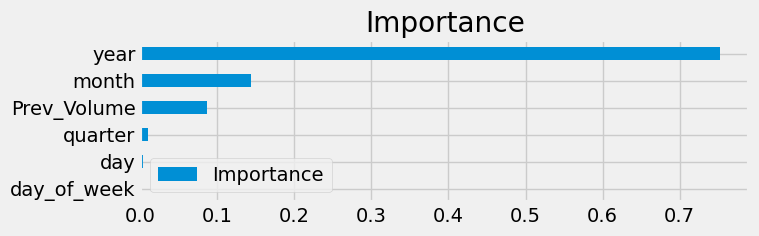

In [6]:
reg_XGB=xgb.XGBRegressor(n_estimator=1000,early_stoping_rounds=50,random_state=s)
reg_RF=RandomForestRegressor(random_state=s)
reg_XGB.fit(X_train,y_train)
reg_RF.fit(X_train,y_train)
y_pred_xgb=reg_XGB.predict(X_test)
y_pred_RF=reg_RF.predict(X_test)
print('The score for XGBoost is {}'.format(reg_XGB.score(X_test,y_test)))
print('The score for RandomForest is {}'.format(reg_RF.score(X_test,y_test)))
d=pd.DataFrame(index=reg_XGB.feature_names_in_,data=reg_XGB.feature_importances_,columns=['Importance']).sort_values('Importance')
d.plot(kind='barh',figsize=(7,2))
plt.title('Importance')
plt.show()


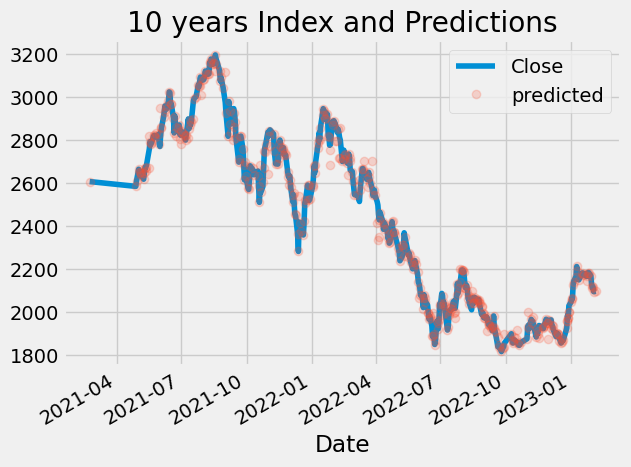

In [7]:
df_n['prediction']=reg_XGB.predict(X)
fig,ax = plt.subplots()
df_n['Close'].plot(ax=ax)
df_n['prediction'].plot(style='o',ax=ax,alpha=0.2,label='predicted')
plt.legend()
plt.title('10 years Index and Predictions')
plt.show()

In [11]:
print(reg_XGB.predict(pd.DataFrame({"Prev_Volume":[1.931719e+09],"year":[2023],"day_of_week":[0],"quarter":[1],"day":[6],"month":[2]})))

[2118.3433]
